# Bacground
In this analysis, OGC APIs and web services were employed through the OWSLib library to investigate and visualize weather data sourced from the GeoMET API. The primary focus was on the "Daily Climate Observations" dataset, specifically targeting the year 2011 in Ottawa, Ontario, Canada, near '560 Rochester St.' The static visualization component involved creating distinct plots for minimum, mean, and maximum temperatures, along with a consolidated plot, and visualizing cumulative precipitation throughout the year. Additionally, a geographic map was generated to illustrate the location of the closest observation station and the provided address. In the subsequent data calculations, seasonal boundaries were defined, and the average mean temperature for each season was computed. The results were presented through visualizations illustrating the variation in mean temperature over time for each season, with indications of the computed average mean temperature. The findings will be documented in a Jupyter Notebook, complemented by a PDF submission.

In [32]:
# Modules importation
from datetime import date                 # Provides date-related functionality
import json                               # Enables JSON encoding and decoding
import math                               # Provides mathematical functions
from textwrap import fill                 # Formats text by filling paragraphs
import cartopy.crs as ccrs                # Cartopy for cartographic projections
from cartopy.io.img_tiles import OSM      # OpenStreetMap (OSM) image tiles for plotting maps
from matplotlib import pyplot as plt, dates as mdates  # Matplotlib for plotting and date formatting
from osgeo import ogr, osr                # GDAL's OGR and OSR modules for geospatial data handling
from owslib.ogcapi.features import Features  # OWSLib for working with OGC API Features
import numpy as np                        # NumPy for numerical operations
import pandas as pd                       # Pandas for data manipulation and analysis
from tabulate import tabulate             # Tabulate for creating formatted tables


# Geocode The ROI-region of interest

In [33]:
from geopy.geocoders import Nominatim

# Create a geolocator
geolocator = Nominatim(user_agent="my_geocoder")

# Specify the address
address = '560 Rochester St, Ottawa, ON, CA'

# Use geocode to get the location (latitude and longitude)
location = geolocator.geocode(address)

# Print the coordinates
if location:
    print(f"Latitude: {location.latitude}, Longitude: {location.longitude}")
else:
    print("Coordinates not found.")


Latitude: 45.39864945, Longitude: -75.70611299803701


# Create parameters for the 2 kilometers buffer zone around our ROI

In [34]:
# Parameters

# Coordinates of 560 Rochester St, Ottawa, ON, CA
lat = 45.3986
long = -75.7061

# Buffer size in kilometres
buffer = 2

# Start and end of the time period for which the data will be retrieved
start_date = date(2011, 1, 1)
end_date = date(2011, 12, 31)

# ESPG code of the preferred projection to create the buffer
# NAD83 / Statistics Canada Lambert
projection = 3347

# Comment next line to use the code outside of a Jupyter Notebook
%matplotlib inline

# Create the buffer zone

In [35]:

# Bounding box a little bigger than buffer size

# The buffer needs to be transformed in degrees to get
# the coordinates of the corners of the bounding box:
# Latitude: 1 km ≈ 0.009° 
# Longitude (at the 49th parallel): 1 km ≈ 0.014°
bbox = [
    long - buffer * 0.02,
    lat - buffer * 0.01,
    long + buffer * 0.02,
    lat + buffer * 0.01,
]

# Formatting of the selected time period
time_ = f"{start_date}/{end_date}"

In [ ]:
# Access data from “Daily Climate Observations” from 
# GeoMET API (https://ecccmsc.github.io/opendata/msc-geomet/readme_en/). Extract data, using the OWSLIB using Jupyter
# Notebook for the closest observation station to '560 Rochester St, Ottawa, ON, CA' for the entirety of
# 2011.

In [36]:
# Retrieval of climatic stations data
oafeat = Features("https://api.weather.gc.ca/")
station_data = oafeat.collection_items(
    "climate-stations", bbox=bbox,LOCAL_YEAR="2011"
)

# Verification of the retrieved data
if "features" in station_data:
    station_data = json.dumps(station_data, indent=4)
else:
    raise ValueError(
        "No Weather stations were found. Please verify the coordinates."
    )

# Get the list of the stations

In [37]:
import warnings
from osgeo import ogr, osr

# List of stations located inside the buffer zone

# Accessing the hydrometric stations layer
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    driver = ogr.GetDriverByName("GeoJSON")
    data_source = driver.Open(station_data, 0)

layer = data_source.GetLayer()

# Identification of the input spatial reference system (SRS)
SRS_input = layer.GetSpatialRef()
SR = osr.SpatialReference(str(SRS_input))
epsg = SR.GetAuthorityCode(None)
SRS_input.ImportFromEPSG(int(epsg))

# Definition of the SRS used to project data
SRS_projected = osr.SpatialReference()
SRS_projected.ImportFromEPSG(projection)

# Transformation from input SRS to the prefered projection
transform = osr.CoordinateTransformation(SRS_input, SRS_projected)

# Creation of a buffer to select stations
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(long, lat)
point.Transform(transform)
point_buffer = point.Buffer(buffer * 1000)  # The value must be in meters

# Selection of the stations in the buffer zone
stations = []

for feature in layer:
    geom = feature.GetGeometryRef().Clone()
    geom.Transform(transform)
    if geom.Intersects(point_buffer):
        stations.append(feature.STATION_NAME)

# Raising an error if no station were found
if not stations:
    raise ValueError(
        f"There are no weather stations within {buffer} km"
        + " of the chosen coordinates. Please verify the coordinates."
    )


# Retrieve the data,then check for Null values

In [39]:
# Retrieval of climatic data for each station

climatic_data = {}

# List of stations with no water level data
stations_without_data = []

# Data retrieval and creation of the data frames
for station in stations:

    # Retrieval of weather data
    climate_data = oafeat.collection_items(
        "climate-daily",
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        STATION_NAME=station,
    )
    # Creation of a data frame if there is data for the chosen time period
    if climate_data["features"]:
        # Creation of a dictionary in a format compatible with Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in climate_data["features"]
        ]
        # Creation of the data frame
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NAME",
                "LOCAL_DATE",
                "MEAN_TEMPERATURE",
                "MIN_TEMPERATURE",
                "MAX_TEMPERATURE",
                "TOTAL_RAIN",
                "TOTAL_PRECIPITATION",
                "LOCAL_YEAR",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)
        
        # Print columns with NaN values
        nan_columns = historical_data_df.columns[historical_data_df.isna().any()].tolist()
        print(f"Columns with NaN values: {nan_columns}")

        # Adding the data frame to the climatic data dictionary
        if not historical_data_df["MEAN_TEMPERATURE"].isnull().all():
            # Removing any rows without weather data at the
            # end of the data frame
            while np.isnan(historical_data_df["MEAN_TEMPERATURE"].iloc[-1]):
                historical_data_df = historical_data_df.drop(
                    historical_data_df.tail(1).index
                )
            # Creating an index with the date in a datetime format
            historical_data_df["LOCAL_DATE"] = pd.to_datetime(
                historical_data_df["LOCAL_DATE"]
            )
            historical_data_df.set_index(["LOCAL_DATE"], inplace=True, drop=True)
            historical_data_df.index = historical_data_df.index.date
            # Adding the data frame to the dictionary
            climatic_data[station] = historical_data_df
        # If all the data is NaN, the station will be removed from the dataset
        else:
            stations_without_data.append(station)
    # If there is no data for the chosen time period, the station
    # will be removed from the dataset
    else:
        stations_without_data.append(station)

# Removing climatic stations without climate data from the station list
for station in stations_without_data:
    stations.remove(station)

# Raising an error if no station is left in the list
if not stations:
    raise ValueError(
        f"No weather data is available in the this {num_months}"
        + " months period for the selected climatic stations."
    )


Columns with NaN values: ['TOTAL_RAIN', 'TOTAL_PRECIPITATION']
Columns with NaN values: ['MEAN_TEMPERATURE', 'MIN_TEMPERATURE', 'MAX_TEMPERATURE', 'TOTAL_RAIN', 'TOTAL_PRECIPITATION']
Columns with NaN values: ['TOTAL_RAIN', 'TOTAL_PRECIPITATION']


# Eliminate Null values

In [42]:
# Retrieval of climatic data for each station
climatic_data = {}

# List of stations with no water level data
stations_without_data = []

# Data retrieval and creation of the data frames
for station in stations:
    # Retrieval of weather data
    climate_data = oafeat.collection_items(
        "climate-daily",
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        STATION_NAME=station,
    )

    # Creation of a data frame if there is data for the chosen time period
    if climate_data["features"]:
        # Creation of a dictionary in a format compatible with Pandas
        historical_data_format = [
            {
                "LATITUDE": el["geometry"]["coordinates"][1],
                "LONGITUDE": el["geometry"]["coordinates"][0],
                **el["properties"],
            }
            for el in climate_data["features"]
        ]
        # Creation of the data frame
        historical_data_df = pd.DataFrame(
            historical_data_format,
            columns=[
                "STATION_NAME",
                "LOCAL_DATE",
                "MEAN_TEMPERATURE",
                "MIN_TEMPERATURE",
                "MAX_TEMPERATURE",
                "TOTAL_RAIN",
                "TOTAL_PRECIPITATION",
                "LOCAL_YEAR",
                "LATITUDE",
                "LONGITUDE",
            ],
        )
        historical_data_df = historical_data_df.fillna(value=np.nan)

        # Print columns with NaN values
        nan_columns = historical_data_df.columns[historical_data_df.isna().any()].tolist()
        print(f"Columns with NaN values: {nan_columns}")

        # Drop rows with NaN values for specific columns
        columns_to_drop_na = ['TOTAL_RAIN', 'TOTAL_PRECIPITATION']
        historical_data_df = historical_data_df.dropna(subset=columns_to_drop_na)

        # Print the resulting data frame
        print(f"Resulting Data Frame for Station {station}:\n{historical_data_df}")

        # Adding the data frame to the climatic data dictionary
        if not historical_data_df["MEAN_TEMPERATURE"].empty:
            # Creating an index with the date in a datetime format
            historical_data_df["LOCAL_DATE"] = pd.to_datetime(
                historical_data_df["LOCAL_DATE"]
            )
            historical_data_df.set_index(["LOCAL_DATE"], inplace=True, drop=True)
            historical_data_df.index = historical_data_df.index.date
            # Adding the data frame to the dictionary
            climatic_data[station] = historical_data_df
        # If all the data is NaN, the station will be removed from the dataset
        else:
            stations_without_data.append(station)
    # If there is no data for the chosen time period, the station
    # will be removed from the dataset
    else:
        stations_without_data.append(station)

# Removing climatic stations without climate data from the station list
for station in stations_without_data:
    stations.remove(station)

# Raising an error if no station is left in the list
if not stations:
    raise ValueError(
        f"No weather data is available in the this {num_months}"
        + " months period for the selected climatic stations."
    )


Columns with NaN values: ['TOTAL_RAIN', 'TOTAL_PRECIPITATION']
Resulting Data Frame for Station OTTAWA CDA:
    STATION_NAME           LOCAL_DATE  MEAN_TEMPERATURE  MIN_TEMPERATURE  \
0     OTTAWA CDA  2011-01-01 00:00:00               4.7              1.7   
1     OTTAWA CDA  2011-01-02 00:00:00              -0.5             -2.2   
2     OTTAWA CDA  2011-01-03 00:00:00              -3.9             -5.8   
3     OTTAWA CDA  2011-01-04 00:00:00              -5.8             -8.4   
4     OTTAWA CDA  2011-01-05 00:00:00              -5.4             -7.0   
..           ...                  ...               ...              ...   
360   OTTAWA CDA  2011-10-22 00:00:00               8.8              6.7   
361   OTTAWA CDA  2011-10-23 00:00:00               7.9              3.8   
362   OTTAWA CDA  2011-10-24 00:00:00               8.0              1.3   
363   OTTAWA CDA  2011-10-25 00:00:00               8.7              6.1   
364   OTTAWA CDA  2011-10-26 00:00:00               4.9 

# Save the data as CSV

In [53]:
# Assuming historical_data_df is your DataFrame
# Replace 'historical_data_df' with the actual DataFrame variable in your case

# Specify the file path
export_path = r'F:\AcPro Basics\Toronto White Cups\Ottawa\historical_data.csv'

# Export the DataFrame to CSV with index and header
historical_data_df.to_csv(export_path, index=True, header=True)

print(f'DataFrame exported to: {export_path}')


DataFrame exported to: F:\AcPro Basics\Toronto White Cups\Ottawa\historical_data.csv


# Import the CSV from the file directory

In [57]:
import os
from pandas import read_csv
from matplotlib import pyplot

# Set the working directory
csv_path = r'F:\AcPro Basics\Toronto White Cups\Ottawa\historical_data.csv'
os.chdir(os.path.dirname(csv_path))

# Read the CSV file into a DataFrame
df = read_csv(csv_path, header=0, index_col=0, parse_dates=True)

# Print the first few rows of the DataFrame
print(df.head())


           STATION_NAME  MEAN_TEMPERATURE  MIN_TEMPERATURE  MAX_TEMPERATURE  \
LOCAL_DATE                                                                    
2011-01-01   OTTAWA CDA               4.7              1.7              7.7   
2011-01-02   OTTAWA CDA              -0.5             -2.2              1.2   
2011-01-03   OTTAWA CDA              -3.9             -5.8             -2.0   
2011-01-04   OTTAWA CDA              -5.8             -8.4             -3.1   
2011-01-05   OTTAWA CDA              -5.4             -7.0             -3.8   

            TOTAL_RAIN  TOTAL_PRECIPITATION  LOCAL_YEAR   LATITUDE  LONGITUDE  
LOCAL_DATE                                                                     
2011-01-01         4.2                  4.2        2011  45.383333 -75.716667  
2011-01-02         0.0                  0.0        2011  45.383333 -75.716667  
2011-01-03         0.0                  0.5        2011  45.383333 -75.716667  
2011-01-04         0.0                  0.9   

In [ ]:
# 1. Create individual plots for minimum, mean and maximum temperature, and a 4th plot of all
# temperatures in one plot using the subplot function and aligning the axes.

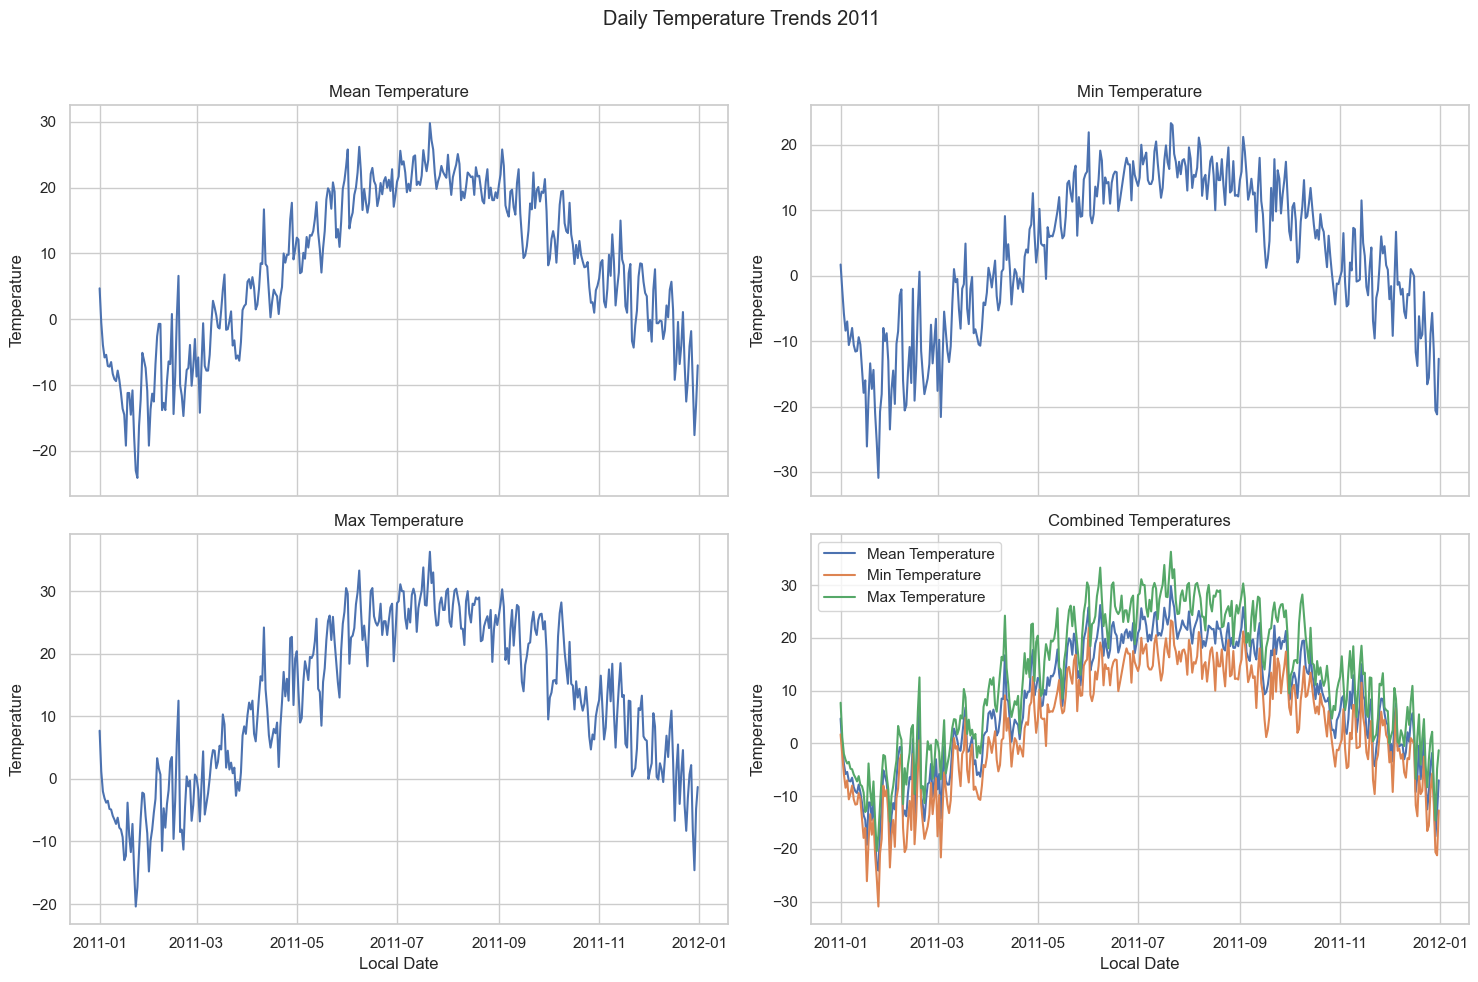

In [71]:
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the full path to the CSV file
csv_path = r'F:\AcPro Basics\Toronto White Cups\Ottawa\historical_data.csv'

# Read the CSV file into a DataFrame
df = read_csv(csv_path, header=0, index_col=0, parse_dates=True)

# Extract the desired Series using indexing
mean_temperature = df['MEAN_TEMPERATURE']
min_temperature = df['MIN_TEMPERATURE']
max_temperature = df['MAX_TEMPERATURE']

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Plot the mean temperature
sns.lineplot(data=mean_temperature, ax=axes[0, 0])
axes[0, 0].set_title('Mean Temperature')
axes[0, 0].set_xlabel('Local Date')
axes[0, 0].set_ylabel('Temperature')

# Plot the min temperature
sns.lineplot(data=min_temperature, ax=axes[0, 1])
axes[0, 1].set_title('Min Temperature')
axes[0, 1].set_xlabel('Local Date')
axes[0, 1].set_ylabel('Temperature')

# Plot the max temperature
sns.lineplot(data=max_temperature, ax=axes[1, 0])
axes[1, 0].set_title('Max Temperature')
axes[1, 0].set_xlabel('Local Date')
axes[1, 0].set_ylabel('Temperature')

# Plot all temperature values in one plot
sns.lineplot(data=mean_temperature, label='Mean Temperature', ax=axes[1, 1])
sns.lineplot(data=min_temperature, label='Min Temperature', ax=axes[1, 1])
sns.lineplot(data=max_temperature, label='Max Temperature', ax=axes[1, 1])
axes[1, 1].set_title('Combined Temperatures')
axes[1, 1].set_xlabel('Local Date')
axes[1, 1].set_ylabel('Temperature')
axes[1, 1].legend()

# Add a common title to the whole plot
fig.suptitle('Daily Temperature Trends 2011')

# Adjust layout to prevent clipping of titles
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


In [ ]:
# 2. Plot the cumulative precipitation over the year.

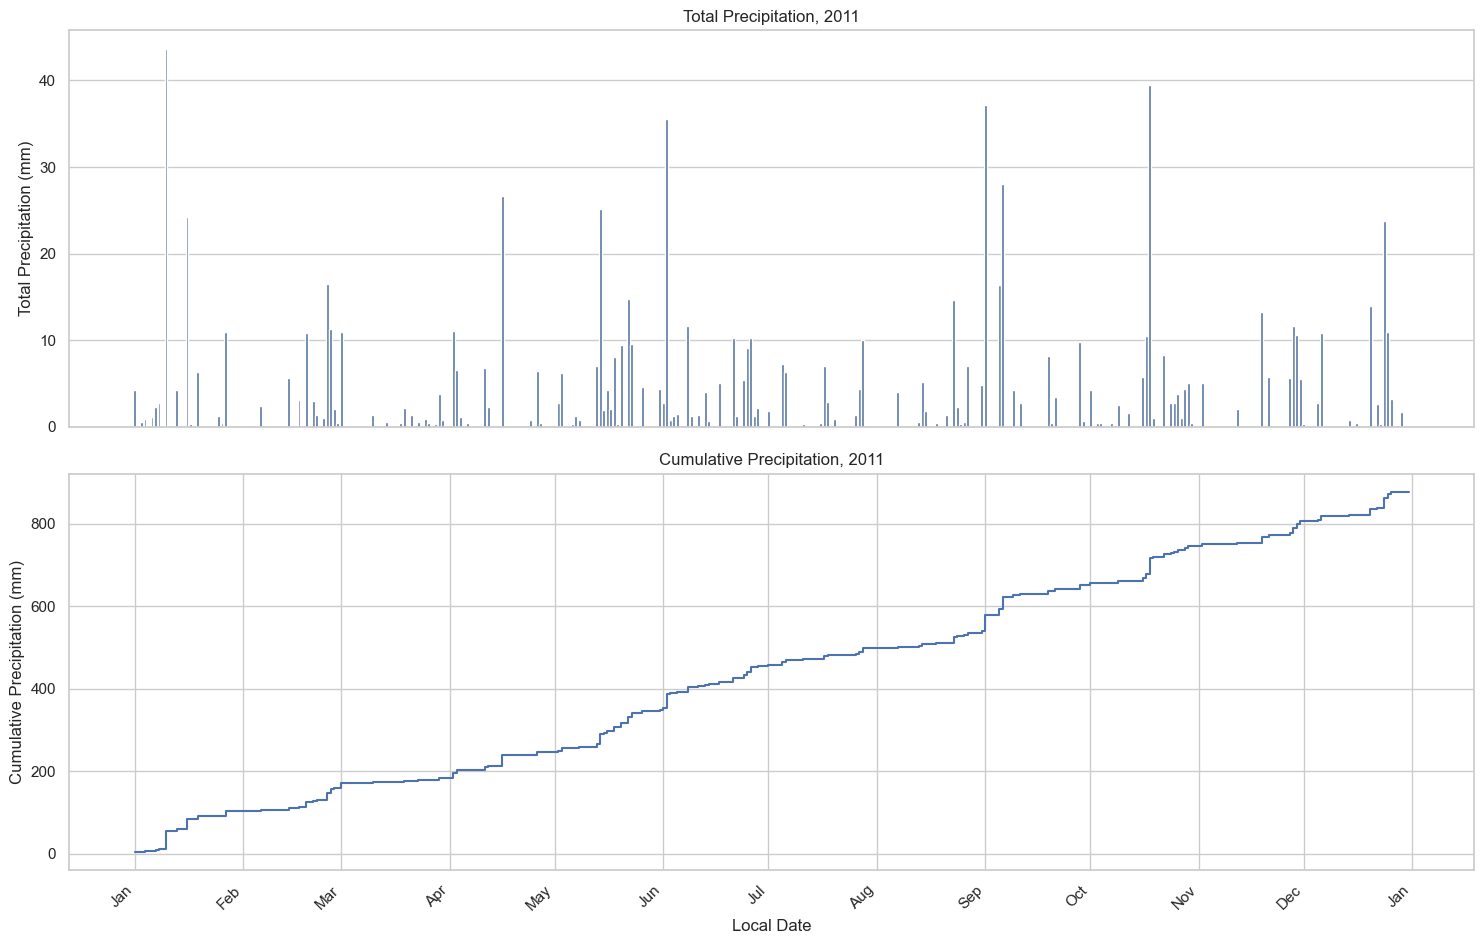

In [87]:
from pandas import read_csv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Specify the full path to the CSV file
csv_path = r'F:\AcPro Basics\Toronto White Cups\Ottawa\historical_data.csv'

# Read the CSV file into a DataFrame
df = read_csv(csv_path, header=0, index_col=0, parse_dates=True)

# Extract the total precipitation Series using indexing
total_precipitation = df['TOTAL_PRECIPITATION']

# Calculate cumulative precipitation
cumulative_precipitation = total_precipitation.cumsum()

# Convert the index to numeric format
cumulative_precipitation.index = range(len(cumulative_precipitation))

# Set Seaborn style
sns.set(style="whitegrid")

# Create a figure with subplots, stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot the total precipitation
sns.barplot(x=total_precipitation.index, y=total_precipitation, ax=axes[0])
axes[0].set_title('Total Precipitation, 2011')
axes[0].set_xlabel('Local Date')
axes[0].set_ylabel('Total Precipitation (mm)')

# Plot the cumulative precipitation as a staircase plot
sns.lineplot(x=cumulative_precipitation.index, y=cumulative_precipitation, drawstyle='steps-post', ax=axes[1])
axes[1].set_title('Cumulative Precipitation, 2011')
axes[1].set_xlabel('Local Date')
axes[1].set_ylabel('Cumulative Precipitation (mm)')

# Format x-axis labels to display only month and year (2011)
axes[1].xaxis.set_major_locator(mdates.MonthLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Manually set x-axis ticks to reduce crowding
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent clipping of titles
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


In [ ]:
# 3. Create a geographic map – plot the location of the closest observation station in a folium map
# using a custom marker with a pop up that provide some details of the station (e.g.: Station
# Name, Station Number, and Latitude, Longitude) and a different style marker at the address
# provided

In [2]:
import folium
from geopy.distance import geodesic

# Function to calculate the distance between two coordinates
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# Example coordinates for the observation station and address
station_coordinates = (45.38333333, -75.71666667)  # Provided coordinates
address_coordinates = (43.6426, -79.3871)  # Replace with actual address coordinates

# Example station details
station_name = "Example Station"
station_number = "12345"

# Create a Folium map centered around the address
map_center = address_coordinates
my_map = folium.Map(location=map_center, zoom_start=14)

# Add custom marker for the observation station
folium.Marker(
    location=station_coordinates,
    popup=f"Station Name: {station_name}<br>Station Number: {station_number}<br>Latitude: {station_coordinates[0]}<br>Longitude: {station_coordinates[1]}",
    icon=folium.Icon(color='blue', icon='cloud')
).add_to(my_map)

# Add a different style marker for the address
folium.Marker(
    location=address_coordinates,
    popup="Ottawa CA",
    icon=folium.Icon(color='green', icon='home')
).add_to(my_map)

# Display the map
my_map.save("map.html")  # Save the map as an HTML file
my_map


In [ ]:
# Part B. Data Calculations
# Using the data you have downloaded in Part A. Calculate the average of the mean temperature for each
# season, using the following dates to denote seasonal boundaries:
# Spring: March 20th
# Summer: June 21st
# Autumn/Fall: Sept 23
# Winter: Dec 21th
# Create a function which generates a plot of each season showing the variation in mean temperature
# throughout the season and indicating the computed average mean temperature in the season. 


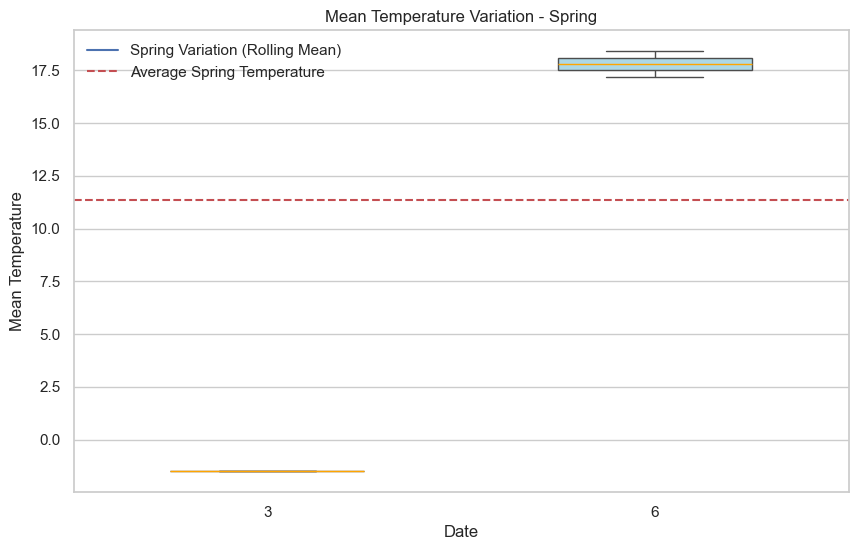

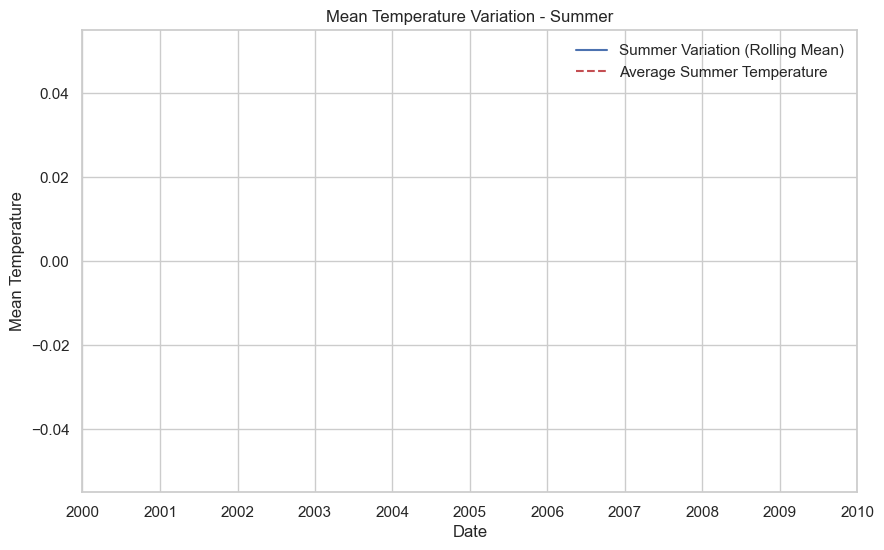

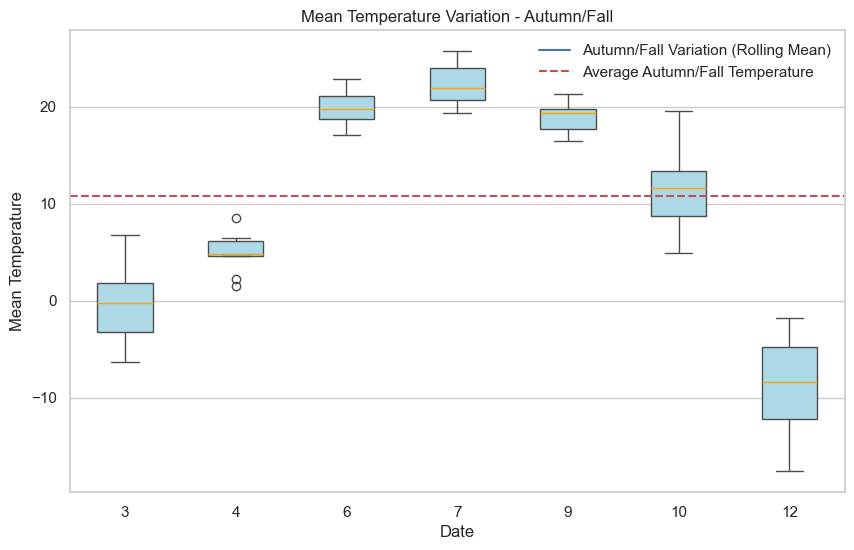

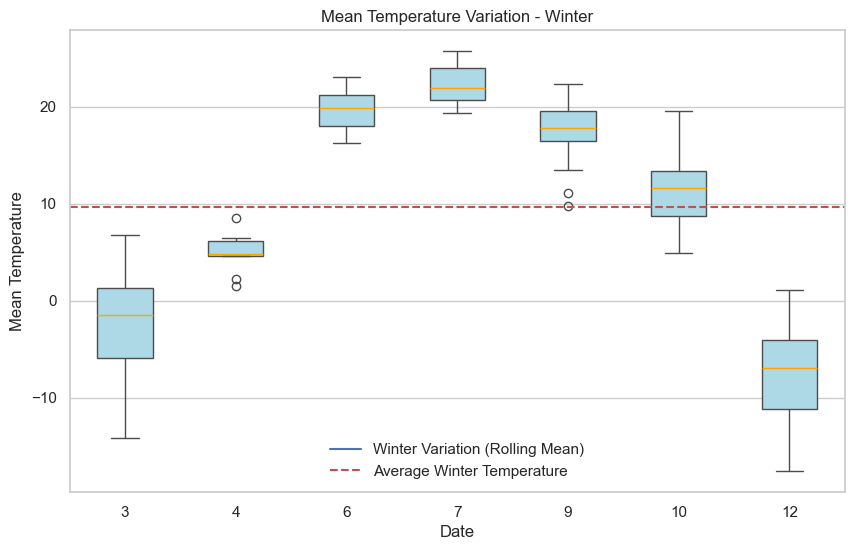

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the full path to the CSV file
csv_path = r'F:\AcPro Basics\Toronto White Cups\Ottawa\historical_data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path, parse_dates=True, index_col='LOCAL_DATE')

# Function to calculate average mean temperature for each season
def calculate_seasonal_average(df, season_start_dates):
    seasonal_averages = {}
    for season, start_date in season_start_dates.items():
        # Calculate end date, ensuring it doesn't exceed the available data
        end_date = min(start_date + pd.DateOffset(months=3), df.index[-1])
        seasonal_data = df[start_date:end_date]
        seasonal_averages[season] = seasonal_data['MEAN_TEMPERATURE'].mean()
    return seasonal_averages

# Function to generate a plot for each season with a rolling mean and box plot
def plot_seasonal_variation(df, season_start_dates, seasonal_averages):
    sns.set(style='whitegrid')

    for season, start_date in season_start_dates.items():
        # Calculate end date, ensuring it doesn't exceed the available data
        end_date = min(start_date + pd.DateOffset(months=3), df.index[-1])
        seasonal_data = df[start_date:end_date]

        # Calculate rolling mean for smoother plots
        rolling_mean = seasonal_data['MEAN_TEMPERATURE'].rolling(window=7, min_periods=1).mean()

        # Create a figure with subplot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the seasonal variation with rolling mean
        ax.plot(seasonal_data.index, rolling_mean, label=f'{season} Variation (Rolling Mean)')

        # Plot the box plot for the seasonal data
        sns.boxplot(x=seasonal_data.index.month, y=seasonal_data['MEAN_TEMPERATURE'], ax=ax, width=0.5,
                    boxprops=dict(facecolor='lightblue'), medianprops=dict(color='orange'))

        # Plot the average mean temperature as a horizontal line
        ax.axhline(y=seasonal_averages[season], color='r', linestyle='--', label=f'Average {season} Temperature')

        ax.set_xlabel('Date')
        ax.set_ylabel('Mean Temperature')
        ax.set_title(f'Mean Temperature Variation - {season}')
        ax.legend()

        # Show the plot
        plt.show()

# Define seasonal boundaries
season_start_dates = {'Spring': pd.Timestamp('2011-03-20'),
                      'Summer': pd.Timestamp('2011-06-21'),
                      'Autumn/Fall': pd.Timestamp('2011-09-23'),
                      'Winter': pd.Timestamp('2011-12-21')}

# Calculate seasonal averages
seasonal_averages = calculate_seasonal_average(df, season_start_dates)

# Plot seasonal variation with average mean temperature using rolling mean and box plots
plot_seasonal_variation(df, season_start_dates, seasonal_averages)

